TensorFlow Version: 2.18.0
Num GPUs Available: 2
Number of GPUs in strategy: 2
Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Validation class distribution: [335 968]
Epoch 1/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.7984 - loss: 9.2357 - precision_1: 0.9214 - recall_1: 0.7968 - val_accuracy: 0.7469 - val_loss: 8.9238 - val_precision_1: 0.7469 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 449ms/step - accuracy: 0.8819 - loss: 7.6878 - precision_1: 0.9655 - recall_1: 0.8710 - val_accuracy: 0.7500 - val_loss: 8.7405 - val_precision_1: 0.7500 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 439ms/step - accuracy: 0.9082 - loss: 6.4693 - precision_1: 0.9758 - recall_1: 0.8984 - val_accuracy: 0.7485 - val_loss: 7.7226 - val_precision_1: 0.7485 - val_recall_1

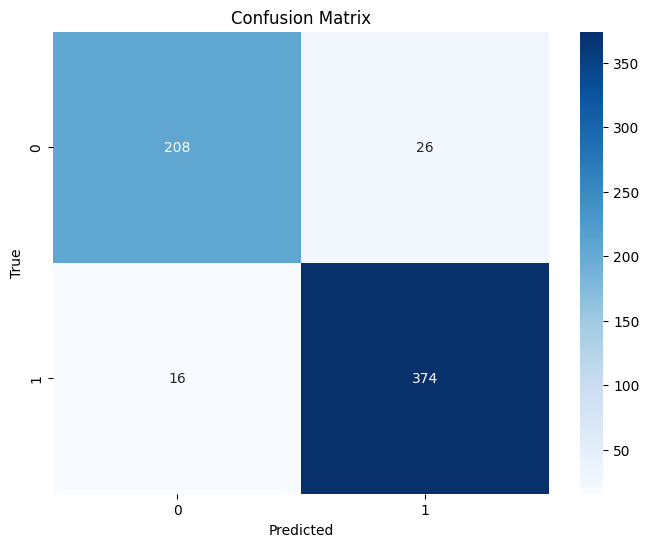

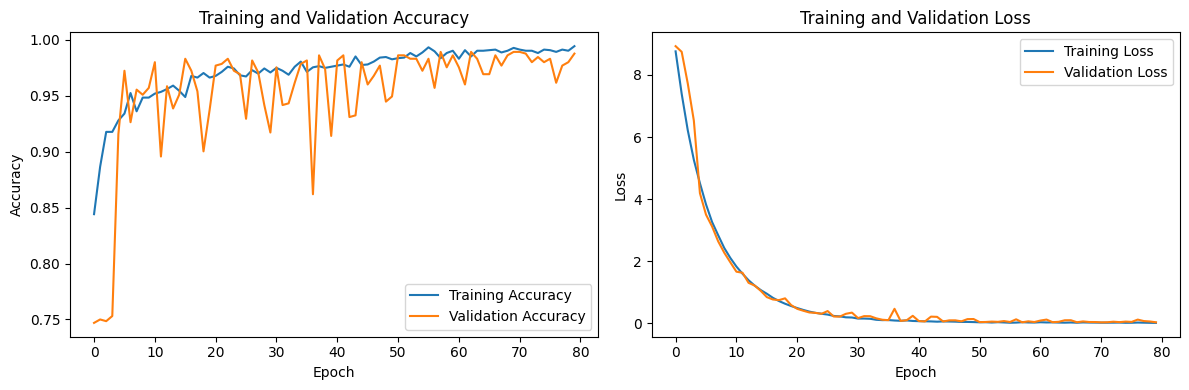


Classification Report for Test Set:
              precision    recall  f1-score   support

      NORMAL       0.93      0.89      0.91       234
   PNEUMONIA       0.94      0.96      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



In [2]:
# The code ran successfully with Kaggle environment and here is the original code

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, GlobalAveragePooling2D, Conv2D, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='keras')

# GPU Check
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()
print("Number of GPUs in strategy:", strategy.num_replicas_in_sync)

# Define data paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Verify dataset
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found: {test_dir}")

with strategy.scope():
    # Data augmentation
    train_val_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25
    )

    # Load training data
    training_data = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        subset='training'
    )

    # Load validation data
    validation_data = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        subset='validation'
    )

    # Test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load test data
    testing_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        shuffle=False
    )

    # Print class indices and validation class distribution
    print("Class indices:", training_data.class_indices)
    print("Validation class distribution:", np.bincount(validation_data.classes))

    # Adjusted class weights
    class_weight_dict = {0: 1.5, 1: 0.5}

    # CNN model architecture
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(224,224,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(1024, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(2048, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
  

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
    model.add(Dropout(0.75))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000005)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    training_data,
    epochs=80,
    validation_data=validation_data,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Load the best model
model.load_weights('/kaggle/working/best_model.keras')

# Evaluate on Validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_data)
print(f"Validation Accuracy After Restoring Best Weights: {val_accuracy:.4f}, Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

# Evaluate on Test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

# Predict on test data
predictions = model.predict(testing_data)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = testing_data.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Plot accuracy and loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/accuracy_loss_curves.png')
plt.show()


# Classification report
print("\nClassification Report for Test Set:")
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))


In [3]:
model.save('/kaggle/working/final_best_model.keras')